# Experimental data processing

🎯 **Goal**: Clean the experimental data for the distance traveled by cells.

---

## Context
The experimental data includes the distances traveled by cells over time. This distance is computed in regards to the cell monolayer at the top of the chip. Since the location of the monolayer is not always correctly detected through the image processing algorithm, the experimental results may appear inconsistent over distinct conditions. Thus, we will estimate the correct position of the initial fibroblast monolayer based  on the minimal traveled distance values and recompute the traveled distances in regards to this new baseline value.

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io as sio

DATA_PATH = Path('raw-data/')
SAVE_PATH = Path('processed-data/')
FILE_STEM = 'multichip_data_'

## 2.5 mg/mL matrix - 96 hours
### Read the experimental data

In [2]:
def read_experimental_data(experimental_conditions):
    """Loads the experimental data stored in .mat files for a given set of conditions."""
    
    # Store data from all conditions in a dict
    data = {}

    for condition in experimental_conditions:
        # Load file
        mat_path = DATA_PATH / f'{FILE_STEM}{condition}.mat'
        mat_file = sio.loadmat(mat_path)
        distance_to_monolayer = mat_file['glob_dist2mono']

        # Format the data from four columns to two columns
        # One column will contain the distances and the other will contain the corresponding day
        distance_to_monolayer = pd.melt(pd.DataFrame(distance_to_monolayer))
        distance_to_monolayer.rename(columns={'variable': 'day', 'value': 'distance'},
                                     inplace=True)
        # Drop the NaN rows
        distance_to_monolayer = distance_to_monolayer.dropna()
        # Convert day column from 0 index notation
        distance_to_monolayer['day'] = distance_to_monolayer['day'] + 1
        distance_to_monolayer['distance'] = distance_to_monolayer['distance']
        distance_to_monolayer['condition'] = condition

        data[condition] = distance_to_monolayer
        
    data_df = pd.concat(data.values())

    return data_df


chemotaxis_conditions = ['control', 'cell_channel', 'opposite_channel']
conditions_labels = ['Control', 'Monolayer chamber', 'Opposite chamber']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df

day  distance         condition
0       1      64.0           control
1       1      75.2           control
2       1      67.2           control
3       1      60.8           control
4       1      57.6           control
...   ...       ...               ...
2855    4      97.6  opposite_channel
2856    4     110.4  opposite_channel
2857    4     153.6  opposite_channel
2858    4     422.4  opposite_channel
2859    4     438.4  opposite_channel

[4206 rows x 3 columns]

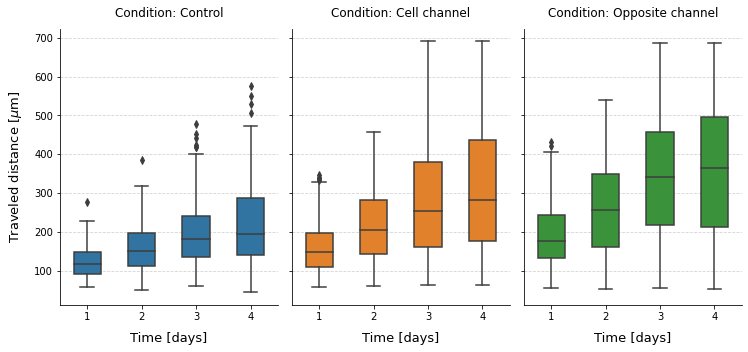

In [3]:
fig = sns.catplot(data=chemotaxis_df, x='day', y='distance', col='condition', hue='condition',
                  kind='box', width=0.5, aspect=0.7, dodge=False)

# Figure style
for ax, condition in zip(fig.axes.flatten(), ['Control', 'Cell channel', 'Opposite channel']):
    ax.set_title(f'Condition: {condition}', y=1.02)
    ax.set_axisbelow(True)
    ax.grid(axis='y', c='lightgrey', linestyle='dashed')
    
fig.set_xlabels('Time [days]', labelpad=10, fontsize=13)
fig.set_ylabels('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
plt.tight_layout()

It appears that minimal traveled distance values are always around 50 microns. We can confirm this by looking into the average minimum value at each day.

In [4]:
# Select each condition and print info on minimum values
for condition in chemotaxis_conditions:
    condition_df = chemotaxis_df[chemotaxis_df['condition'] == condition]
    minimum_values = condition_df.groupby('day')['distance'].describe()['min']
    print(f'Condition: {condition}')
    print(f'Mean minimum value: {round(minimum_values.mean(), 2)}')
    print(f'Minimum value: {round(minimum_values.min(), 2)}')
    print()

Condition: control
Mean minimum value: 53.6
Minimum value: 44.8

Condition: cell_channel
Mean minimum value: 61.2
Minimum value: 59.2

Condition: opposite_channel
Mean minimum value: 54.8
Minimum value: 52.8



### Fix the baseline

We will use the average minimum traveled distance over the 4 days to locate the "real" location of the monolayer, assuming that some of the cells are still attached to this structure. Thus, we consider that the minimal distance values correspond to these cells, and, consequently, to the location of the monolayer. We will also assume that any distance value lower than 0 will be set to 0.

In [5]:
def fix_distance_baseline(data_df):
    """Computes new distance values based on the predicted monolayer location"""
    
    data_df['fixed_distance'] = np.NaN

    # Select each condition and print info on minimum values
    for condition in data_df.condition.unique():
        condition_indexes = list(data_df[data_df['condition'] == condition].index)
        condition_df = data_df.loc[condition_indexes]
        minimum_values = condition_df.groupby('day')['distance'].describe()['min']
        baseline_value = minimum_values.mean()
        data_df.loc[condition_indexes, 'fixed_distance'] = \
            data_df.loc[condition_indexes, 'distance'] - baseline_value

    data_df.loc[data_df['fixed_distance'] < 0, 'fixed_distance'] = 0
    
    return data_df

chemotaxis_df = fix_distance_baseline(chemotaxis_df)

# Rename the conditions to keep it consistent
chemotaxis_df['condition'] = chemotaxis_df['condition'].map({condition: label 
                                                            for condition, label
                                                            in zip(chemotaxis_conditions, conditions_labels)})

chemotaxis_df

day  distance         condition  fixed_distance
0       1      64.0           Control            10.0
1       1      75.2           Control            21.2
2       1      67.2           Control            13.2
3       1      60.8           Control             6.8
4       1      57.6           Control             3.6
...   ...       ...               ...             ...
2855    4      97.6  Opposite chamber            43.6
2856    4     110.4  Opposite chamber            56.4
2857    4     153.6  Opposite chamber            99.6
2858    4     422.4  Opposite chamber           368.4
2859    4     438.4  Opposite chamber           384.4

[4206 rows x 4 columns]

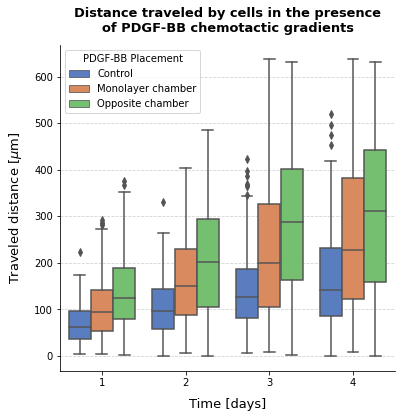

In [6]:
sns.set_palette('muted', 3)

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=chemotaxis_df, x='day', y='fixed_distance', hue='condition', ax=ax)

# Figure style
ax.set_title(f'Distance traveled by cells in the presence\nof PDGF-BB chemotactic gradients', y=1.02, 
             fontsize=13, fontweight='bold')

ax.set_axisbelow(True)
ax.grid(axis='y', c='lightgrey', linestyle='dashed')

ax.set_xlabel('Time [days]', labelpad=10, fontsize=13)
ax.set_ylabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)

plt.legend(title='PDGF-BB Placement')
sns.despine()

### Save the data

We will be saving the data as histograms in order to easily compute the BC between experimental and computational data. 

We will save a `.csv` file for each day.

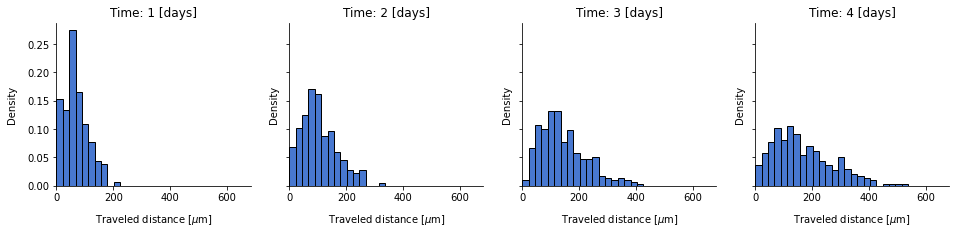

In [7]:
# Define histogram bins
distance_range = 650
number_of_bins = 30
bins = np.linspace(0, distance_range, number_of_bins)

control_df = chemotaxis_df[chemotaxis_df['condition'] == 'Control'].copy()

# Plot figure (each column represents a day)
fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=True, sharex=True)

for i, ax in enumerate(axes):
    distance_at_day = control_df[control_df['day'] == i+1]['fixed_distance']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, edgecolor='black')
    ax.set_xlim(0, None)
    ax.set_title(f'Time: {i+1} [days]')
    ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10)
    ax.set_ylabel('Density', labelpad=10)
    #np.savetxt(SAVE_PATH / f'chemo96_control_hist_day_{i+1}.csv', hist, delimiter=",")
    
sns.despine(fig)

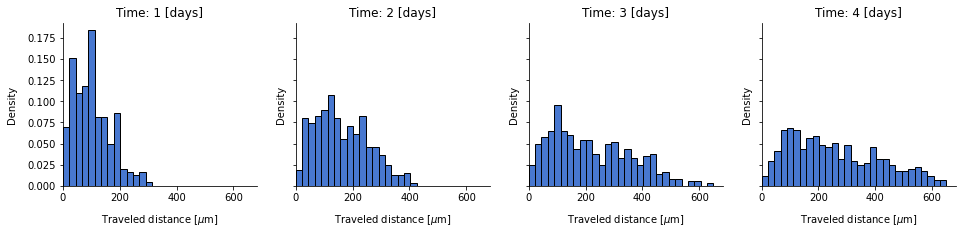

In [8]:
# Define histogram bins
distance_range = 650
number_of_bins = 30
bins = np.linspace(0, distance_range, number_of_bins)

control_df = chemotaxis_df[chemotaxis_df['condition'] == 'Monolayer chamber'].copy()

# Plot figure (each column represents a day)
fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=True, sharex=True)

for i, ax in enumerate(axes):
    distance_at_day = control_df[control_df['day'] == i+1]['fixed_distance']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, edgecolor='black')
    ax.set_xlim(0, None)
    ax.set_title(f'Time: {i+1} [days]')
    ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10)
    ax.set_ylabel('Density', labelpad=10)
    #np.savetxt(SAVE_PATH / f'chemo96_cell_channel_hist_day_{i+1}.csv', hist, delimiter=",")
    
sns.despine(fig)

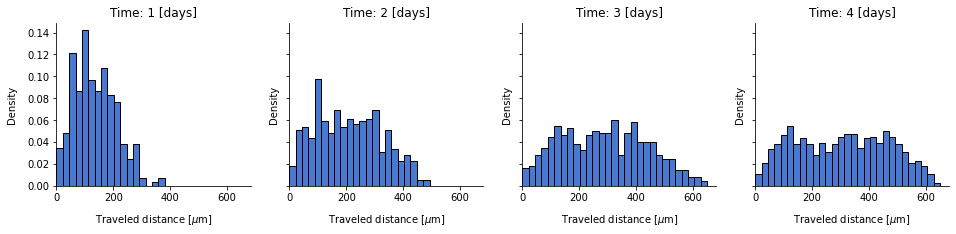

In [9]:
# Define histogram bins
distance_range = 650
number_of_bins = 30
bins = np.linspace(0, distance_range, number_of_bins)

control_df = chemotaxis_df[chemotaxis_df['condition'] == 'Opposite chamber'].copy()

# Plot figure (each column represents a day)
fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=True, sharex=True)

for i, ax in enumerate(axes):
    distance_at_day = control_df[control_df['day'] == i+1]['fixed_distance']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, edgecolor='black')
    ax.set_xlim(0, None)
    ax.set_title(f'Time: {i+1} [days]')
    ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10)
    ax.set_ylabel('Density', labelpad=10)
    #np.savetxt(SAVE_PATH / f'chemo96_opposite_channel_hist_day_{i+1}.csv', hist, delimiter=",")
    
sns.despine(fig)

We can now repeat this process for the remaining data: 2.5 mg/mL matrix - 216 hours, and 4.0 mg/mL matrix - 96 hours.

## 2.5 mg/mL matrix - 216 hours

In [15]:
# Read and fix data
chemotaxis_conditions = ['control_216h', 'factor_216h']
conditions_labels = ['Control', 'Opposite chamber']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df = fix_distance_baseline(chemotaxis_df)

# Fix the times at which the information was stored
convert_days = {old: new 
                for old, new in zip(range(1, 9), [0, 1, 2, 3, 4, 7, 8, 9])}  

chemotaxis_df['day'] = chemotaxis_df['day'].map(convert_days)
chemotaxis_df = chemotaxis_df[chemotaxis_df['day'] != 0]

# Rename conditions for consistency
chemotaxis_df['condition'] = chemotaxis_df['condition'].map({condition: label 
                                                            for condition, label
                                                            in zip(chemotaxis_conditions, conditions_labels)})

chemotaxis_df

day  distance         condition  fixed_distance
301     1     72.45           Control         26.5650
302     1     66.01           Control         20.1250
303     1     59.57           Control         13.6850
304     1     59.57           Control         13.6850
305     1     66.01           Control         20.1250
...   ...       ...               ...             ...
6607    9    750.26  Opposite chamber        708.8025
6608    9    375.13  Opposite chamber        333.6725
6609    9    354.20  Opposite chamber        312.7425
6610    9    281.75  Opposite chamber        240.2925
6611    9    268.87  Opposite chamber        227.4125

[5545 rows x 4 columns]

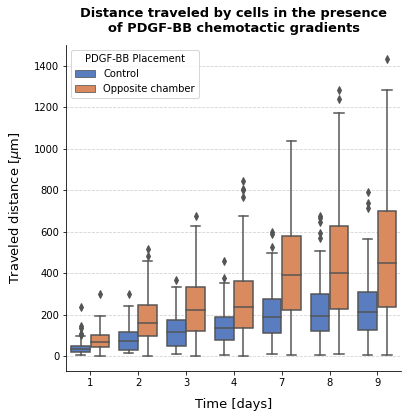

In [16]:
# Plot fixed distance results
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=chemotaxis_df, x='day', y='fixed_distance', hue='condition', ax=ax)

# Figure style
ax.set_title(f'Distance traveled by cells in the presence\nof PDGF-BB chemotactic gradients', y=1.02, 
             fontsize=13, fontweight='bold')

ax.set_axisbelow(True)
ax.grid(axis='y', c='lightgrey', linestyle='dashed')

ax.set_xlabel('Time [days]', labelpad=10, fontsize=13)
ax.set_ylabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)

plt.legend(title='PDGF-BB Placement')
sns.despine()

### Save data

In [17]:
# Define histogram bins
distance_range = 1450
number_of_bins = 60
bins = np.linspace(0, distance_range, number_of_bins)

control_df = chemotaxis_df[chemotaxis_df['condition'] == 'Control'].copy()

for i in range(10):
    distance_at_day = control_df[control_df['day'] == i]['fixed_distance']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist, bins = np.histogram(distance_at_day, weights=weights, bins=bins)
    #np.savetxt(SAVE_PATH / f'chemo216_control_hist_day_{i}.csv', hist, delimiter=",")

In [ ]:
# Define histogram bins
distance_range = 1450
number_of_bins = 60
bins = np.linspace(0, distance_range, number_of_bins)

control_df = chemotaxis_df[chemotaxis_df['condition'] == 'Opposite chamber'].copy()

for i in range(10):
    distance_at_day = control_df[control_df['day'] == i]['fixed_distance']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist, bins = np.histogram(distance_at_day, weights=weights, bins=bins)
    #np.savetxt(SAVE_PATH / f'chemo216_opposite_hist_day_{i}.csv', hist, delimiter=",")

## 4 mg/mL matrix - 96 hours

In [10]:
# Read and fix data
chemotaxis_conditions = ['4mg_control', '4mg_factor']
conditions_labels = ['Control', 'Opposite channel']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df = fix_distance_baseline(chemotaxis_df)

# Rename conditions for consistency
chemotaxis_df['condition'] = chemotaxis_df['condition'].map({condition: label 
                                                            for condition, label
                                                            in zip(chemotaxis_conditions, conditions_labels)})

chemotaxis_df

day  distance         condition  fixed_distance
0       1    144.90           Control        116.3225
1       1    180.32           Control        151.7425
2       1    111.09           Control         82.5125
3       1     78.89           Control         50.3125
4       1     67.62           Control         39.0425
...   ...       ...               ...             ...
3435    4    172.27  Opposite channel        143.6925
3436    4    218.96  Opposite channel        190.3825
3437    4    652.05  Opposite channel        623.4725
3438    4    635.95  Opposite channel        607.3725
3439    4    679.42  Opposite channel        650.8425

[3560 rows x 4 columns]

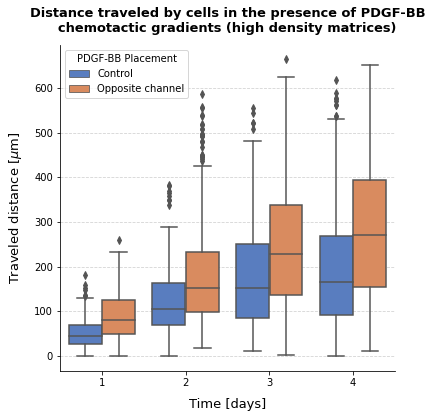

In [11]:
# Plot fixed distance results
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=chemotaxis_df, x='day', y='fixed_distance', hue='condition', ax=ax)

# Figure style

ax.set_axisbelow(True)
ax.grid(axis='y', c='lightgrey', linestyle='dashed')

ax.set_title(f'Distance traveled by cells in the presence of PDGF-BB\nchemotactic gradients (high density matrices)', y=1.02, 
             fontsize=13, fontweight='bold')
    
ax.set_xlabel('Time [days]', labelpad=10, fontsize=13)
ax.set_ylabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)

plt.legend(title='PDGF-BB Placement')

sns.despine()

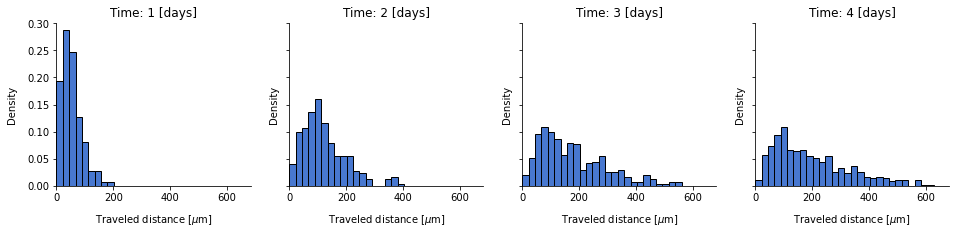

In [12]:
# Define histogram bins
distance_range = 650
number_of_bins = 30
bins = np.linspace(0, distance_range, number_of_bins)

control_df = chemotaxis_df[chemotaxis_df['condition'] == 'Control'].copy()

# Plot figure (each column represents a day)
fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=True, sharex=True)

for i, ax in enumerate(axes):
    distance_at_day = control_df[control_df['day'] == i+1]['fixed_distance']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, edgecolor='black')
    ax.set_xlim(0, None)
    ax.set_title(f'Time: {i+1} [days]')
    ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10)
    ax.set_ylabel('Density', labelpad=10)
    #np.savetxt(SAVE_PATH / f'4mg_control_hist_day_{i+1}.csv', hist, delimiter=",")
    
sns.despine(fig)

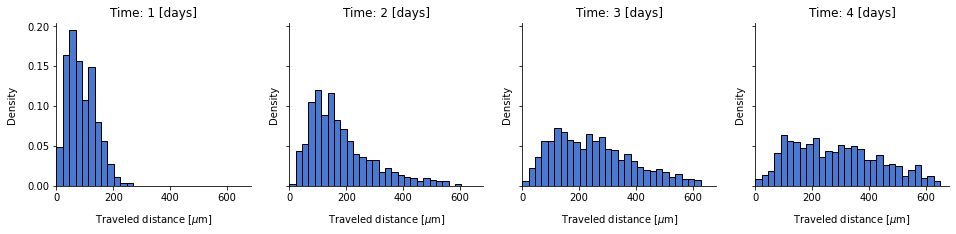

In [13]:
# Define histogram bins
distance_range = 650
number_of_bins = 30
bins = np.linspace(0, distance_range, number_of_bins)

control_df = chemotaxis_df[chemotaxis_df['condition'] == 'Opposite channel'].copy()

# Plot figure (each column represents a day)
fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=True, sharex=True)

for i, ax in enumerate(axes):
    distance_at_day = control_df[control_df['day'] == i+1]['fixed_distance']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, edgecolor='black')
    ax.set_xlim(0, None)
    ax.set_title(f'Time: {i+1} [days]')
    ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10)
    ax.set_ylabel('Density', labelpad=10)
    #np.savetxt(SAVE_PATH / f'4mg_opposite_channel_hist_day_{i+1}.csv', hist, delimiter=",")
    
sns.despine(fig)